<a href="https://colab.research.google.com/github/yangchangnaihoby/AI_7th/blob/master/Day_045_NLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 38.2 MB/s 


In [39]:
data = pd.read_csv('ChatbotData.csv')
data.loc[data['label'] == 0, 'label'] = -1
data.loc[data['label'] == 1, 'label'] = 0
data.loc[data['label'] == -1, 'label'] = 1
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,1
1,1지망 학교 떨어졌어,위로해 드립니다.,1
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,1
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,1
4,PPL 심하네,눈살이 찌푸려지죠.,1


In [67]:
data_0 = data[data['label'] == 0]
data_0.head()

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요,0
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요,0
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요,0
5293,10년 연예의끝,더 마음이 허하겠어요,0
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요,0


In [68]:
data_1 = data[data['label'] == 1]
data_1.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요,1
1,1지망 학교 떨어졌어,위로해 드립니다,1
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠,1
4,PPL 심하네,눈살이 찌푸려지죠,1
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요,1


In [69]:
data_2 = data[data['label'] == 2]
data_2.head()

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요,2
8865,1년반 만났는데 결혼하자고 해도 될까?,기다리고 있을지도 몰라요,2


In [72]:
data['A'].nunique(), data['label'].nunique()

(7751, 3)

In [73]:
data['Q'].nunique(), data['label'].nunique()

(7727, 3)

In [74]:
len(data)

7779

In [75]:
data.drop_duplicates(subset = ['A'], inplace = True)
data.drop_duplicates(subset = ['Q'], inplace = True)

In [76]:
len(data)

7700

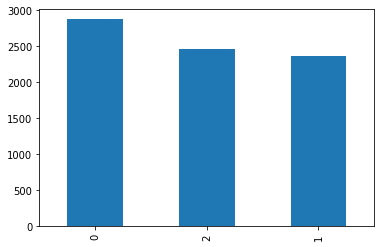

In [77]:
data['label'].value_counts().plot(kind = 'bar')

In [78]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   2877
1      1   2364
2      2   2459


In [79]:
print(data.isnull().values.any())

False


In [80]:
data['A'] = data['A'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data['Q'] = data['Q'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data[ : 5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Q,A,label
0,시 땡,하루가 또 가네요,1
1,지망 학교 떨어졌어,위로해 드립니다,1
2,박일 놀러가고 싶다,여행은 언제나 좋죠,1
4,심하네,눈살이 찌푸려지죠,1
5,카드 망가졌어,다시 새로 사는 게 마음 편해요,1


In [81]:
data['A'] = data['A'].str.replace('^ +', "")
data['A'].replace('', np.nan, inplace = True)
data['Q'] = data['Q'].str.replace('^ +', "")
data['Q'].replace('', np.nan, inplace = True)
print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍',
             '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [83]:
okt = Okt()

In [84]:
X_train = []

for sentence in tqdm(data['Q']) :
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 7700/7700 [00:09<00:00, 784.26it/s]


In [85]:
print(X_train[ : 3])

[['시', '땡'], ['지망', '학교', '떨어지다'], ['박일', '놀다', '가다', '싶다']]


In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [87]:
print(tokenizer.word_index)

{'좋아하다': 1, '사람': 2, '있다': 3, '을': 4, '나': 5, '너무': 6, '싶다': 7, '같다': 8, '사랑': 9, '이별': 10, '안': 11, '내': 12, '보다': 13, '되다': 14, '좋다': 15, '헤어지다': 16, '없다': 17, '거': 18, '썸': 19, '한테': 20, '연락': 21, '어떻다': 22, '남자': 23, '돼다': 24, '것': 25, '오다': 26, '남자친구': 27, '못': 28, '짝남': 29, '여자친구': 30, '가다': 31, '만나다': 32, '말': 33, '년': 34, '연애': 35, '오늘': 36, '뭐': 37, '만': 38, '마음': 39, '친구': 40, '자다': 41, '다': 42, '생각': 43, '여자': 44, '하고': 45, '왜': 46, '에서': 47, '인데': 48, '먹다': 49, '이다': 50, '타다': 51, '힘드다': 52, '힘들다': 53, '랑': 54, '모르다': 55, '이제': 56, '알다': 57, '애': 58, '게': 59, '그': 60, '받다': 61, '또': 62, '후': 63, '짝녀': 64, '수': 65, '결혼': 66, '다시': 67, '고': 68, '않다': 69, '이랑': 70, '해': 71, '로': 72, '그녀': 73, '아니다': 74, '들다': 75, '잊다': 76, '짝사랑': 77, '시간': 78, '일': 79, '사귀다': 80, '때': 81, '끄다': 82, '나르다': 83, '더': 84, '해주다': 85, '괜찮다': 86, '많다': 87, '정말': 88, '많이': 89, '중': 90, '에게': 91, '자꾸': 92, '너': 93, '날': 94, '고백': 95, '나다': 96, '아프다': 97, '이야': 98, '달': 99, '인': 100, '선물': 101, '꿈': 102

In [88]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items() :
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold) :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 3932
등장 빈도가 1번 이하인 희귀 단어의 수 : 1825
단어 집합에서 희귀 단어의 비율 : 46.41403865717192
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 5.382845681925437


In [89]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 2108


In [90]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [91]:
print(X_train[ : 3])

[[509], [388, 273], [202, 31, 7]]


In [110]:
y_train = np.array(data['label'])
print(y_train.shape)

(7700,)


In [93]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [94]:
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

7651
7651


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


문장의 최대 길이 : 16
문장의 평균 길이 : 4.192785256829173


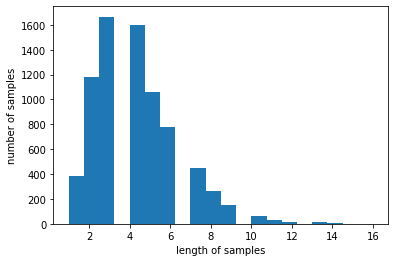

In [97]:
print('문장의 최대 길이 :', max(len(text) for text in X_train))
print('문장의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(text) for text in X_train], bins = 20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [98]:
def below_threshold_len(max_len, nested_list) :
  count = 0
  for sentence in nested_list :
    if(len(sentence) <= max_len) :
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (count / len(nested_list)) * 100))

In [101]:
max_len = 9
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 9 이하인 샘플의 비율: 98.35315645013723


In [102]:
X_train = pad_sequences(X_train, maxlen = max_len)

In [103]:
print(X_train)

[[   0    0    0 ...    0    0  509]
 [   0    0    0 ...    0  388  273]
 [   0    0    0 ...  202   31    7]
 ...
 [   0    0    0 ...   25  643 2035]
 [   0    0    0 ...    0   85   29]
 [  52   35   15 ...  177  571   50]]


In [106]:
embedding_dim = 32
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation = 'softmax'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 100, callbacks = [es, mc], batch_size = 64, validation_split = 0.2, verbose = 2)

Epoch 1/100


ValueError: ignored